In [ ]:
# path = '/content/drive/My Drive/IP Data/data.csv'
path = "IP Data Robot Actions - IP Data.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy
import pandas as pd
import keras

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras import backend as K

In [ ]:
def to_one(arr):
  vals = list(set(arr))
  ar = []
  for i in range(len(arr)):
    ar.append(vals.index(arr[i]))
  return to_categorical(ar),vals

# DL Model



In [ ]:
d = pd.read_csv(path, header=None).to_numpy()
data = []
for i in range(1,len(d)):
  data.append( [d[i][1], d[i][2], d[i][3], d[i-1][4]] )
  if d[i][4]=="NoAction": 
    data[-1][-1] = 0
  else:
    data[-1][-1] = 1

In [ ]:
Data = []
for i in range(0,len(data),5):
  l = False
  for j in range(i,min(i+5,len(data))):
    if data[j][-1] == 1:
      l = True
  d = []
  if l:
    for j in range(i,min(i+5,len(data))):
      if data[j][-1] == 1:
        d = data[j]
        d[1] = data[i][1]
  else:
    d = data[i]
  Data.append(d)

In [ ]:
day = []
time = []
hour = []
minute = []
loct = []
y = []
for i in range(len(Data)):
  day.append(Data[i][0])
  time.append(Data[i][1])
  colon = Data[i][1].find(':')
  hour.append(int(Data[i][1][:colon]))
  minute.append(int(Data[i][1][colon+1:]))
  loct.append(Data[i][2])
  y.append(Data[i][3])
hour = numpy.array(hour)
minute = numpy.array(minute)
Y = numpy.array(y)

In [ ]:
day, _ = to_one(day)
loct, _ = to_one(loct)

In [ ]:
print(day.shape,loct.shape,hour.shape,minute.shape,Y.shape)

(63360, 7) (63360, 11) (63360,) (63360,) (63360,)


In [ ]:
trainX = [day[:50000],loct[:50000],hour[:50000],minute[:50000]]
trainY = Y[:50000]
valX_dl = [day[50000:],loct[50000:],hour[50000:],minute[50000:]]
valY = Y[50000:]

In [ ]:
Days = Input(shape=(7,))
Locts = Input(shape=(11,))
Hours = Input(shape=(1,))
Minutes = Input(shape=(1,))

Day = Dense(8, activation="relu", input_shape=(7,))(Days)

Loct = Dense(8, activation="relu", input_shape=(11,))(Locts)

Hour = Dense(8, activation="relu", input_shape=(1,))(Hours)
Minute = Dense(8, activation="relu", input_shape=(1,))(Minutes)
Time = concatenate([Hour, Minute])
Time = Dense(8, activation="relu")(Time)

X = concatenate([Day, Loct, Time])
y = Dense(1, activation="sigmoid")(X)

model = Model(inputs=[Days, Locts, Hours, Minutes], outputs=y)
opt = Adam(lr=0.001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model_dl.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX_dl, valY), batch_size=64,
    epochs=40, callbacks=[mc], verbose=1, class_weight={0:1,1:7})

Epoch 1/40
782/782 [==============================] - 3s 4ms/step - loss: 1.1942 - accuracy: 0.5501 - val_loss: 0.6077 - val_accuracy: 0.6424
Epoch 2/40
782/782 [==============================] - 3s 3ms/step - loss: 1.0502 - accuracy: 0.6296 - val_loss: 0.6388 - val_accuracy: 0.6359
Epoch 3/40
782/782 [==============================] - 3s 3ms/step - loss: 1.0477 - accuracy: 0.6267 - val_loss: 0.6846 - val_accuracy: 0.6359
Epoch 4/40
782/782 [==============================] - 3s 3ms/step - loss: 1.0474 - accuracy: 0.6264 - val_loss: 0.5914 - val_accuracy: 0.6359
Epoch 5/40
782/782 [==============================] - 3s 3ms/step - loss: 1.0451 - accuracy: 0.6257 - val_loss: 0.6426 - val_accuracy: 0.6361
Epoch 6/40
782/782 [==============================] - 3s 4ms/step - loss: 1.0456 - accuracy: 0.6254 - val_loss: 0.5957 - val_accuracy: 0.6359
Epoch 7/40
782/782 [==============================] - 3s 4ms/step - loss: 1.0453 - accuracy: 0.6258 - val_loss: 0.6140 - val_accuracy: 0.6359
Epoch 

In [ ]:
model = load_model("Best_Model_dl.h5")
Ypred = model.predict(valX_dl)
print(classification_report(valY,Ypred.round()))

# Ensemble


In [ ]:
def makeData(ar, labels):
  vals = numpy.unique(ar)
  dic = {}
  for i in range(len(ar)):
    val = ar[i]
    l = labels[i]
    if val not in dic:
      dic[val] = [0,0]
    dic[val][l] += 1
  for k in dic:
    s = dic[k][0] + dic[k][1]
    dic[k][0] /= s
    dic[k][1] /= s 
  newAr = []
  for i in ar:
    newAr.append(dic[i][1])
  return newAr

In [ ]:
d = pd.read_csv("IP Data Robot Actions - IP Data.csv", header=None).to_numpy()
data = []
for i in range(1,len(d)):
  data.append( [d[i][1], d[i][2], d[i][3], d[i-1][4]] )
  if d[i][4]=="NoAction": 
    data[-1][-1] = 0
  else:
    data[-1][-1] = 1

In [ ]:
Data = []
for i in range(0,len(data),15):
  l = False
  for j in range(i,min(i+15,len(data))):
    if data[j][-1] == 1:
      l = True
  d = []
  if l:
    for j in range(i,min(i+15,len(data))):
      if data[j][-1] == 1:
        d = data[j]
        d[1] = data[i][1]
  else:
    d = data[i]
  Data.append(d)

In [ ]:
day = []
time = []
hour = []
minute = []
loct = []
y = []
for i in range(len(Data)):
  day.append(Data[i][0])
  time.append(Data[i][1])
  colon = Data[i][1].find(':')
  hour.append(int(Data[i][1][:colon]))
  minute.append(int(Data[i][1][colon+1:]))
  loct.append(Data[i][2])
  y.append(Data[i][3])
hour = numpy.array(hour)
minute = numpy.array(minute)
Y = numpy.array(y)

In [ ]:
timeProb = numpy.array(makeData(time,Y))
locProb = numpy.array(makeData(loct,Y))

In [ ]:
day, _ = to_one(day)
loct, _ = to_one(loct)

In [ ]:
X = []
window = 100
for i in range(window,len(Y)):  
  X.append(Y[i-window:i])
X = numpy.array(X)
X = X.reshape((X.shape[0],window,1))

In [ ]:
print(day.shape,loct.shape,hour.shape,minute.shape,timeProb.shape,locProb.shape,Y.shape,X.shape)

(21120, 7) (21120, 11) (21120,) (21120,) (21120,) (21120,) (21120,) (21020, 100, 1)


In [ ]:
# trainX = [day[window:50000],loct[window:50000],hour[window:50000],minute[window:50000],timeProb[window:50000],locProb[window:50000],X[:50000-window]]
# trainY = Y[window:50000]
# valX = [day[50000:],loct[50000:],hour[50000:],minute[50000:],timeProb[50000:],locProb[50000:],X[50000-window:]]
# valY = Y[50000:]
# trainX = [day[window:25000],loct[window:25000],hour[window:25000],minute[window:25000],timeProb[window:25000],locProb[window:25000],X[:25000-window]]
# trainY = Y[window:25000]
# valX = [day[25000:],loct[25000:],hour[25000:],minute[25000:],timeProb[25000:],locProb[25000:],X[25000-window:]]
# valY = Y[25000:]
trainX = [day[window:16000],loct[window:16000],hour[window:16000],minute[window:16000],timeProb[window:16000],locProb[window:16000],X[:16000-window]]
trainY = Y[window:16000]
valX = [day[16000:],loct[16000:],hour[16000:],minute[16000:],timeProb[16000:],locProb[16000:],X[16000-window:]]
valY = Y[16000:]

In [ ]:
Days = Input(shape=(7,))
Locts = Input(shape=(11,))
Hours = Input(shape=(1,))
Minutes = Input(shape=(1,))
TProb = Input(shape=(1,))
LProb = Input(shape=(1,))
LSTMI = Input(shape=(window,1))

Day = Dense(8, activation="relu", input_shape=(7,))(Days)

Loct = Dense(8, activation="relu", input_shape=(11,))(Locts)

Hour = Dense(8, activation="relu", input_shape=(1,))(Hours)
Minute = Dense(8, activation="relu", input_shape=(1,))(Minutes)
Time = concatenate([Hour, Minute])
Time = Dense(8, activation="relu")(Time)

com = concatenate([Day, Loct, Time])
yD = Dense(1, activation="relu")(com)

lstmy = LSTM(1)(LSTMI)
lstmy = Dense(1,activation='relu')(lstmy)

y = concatenate([yD,TProb,LProb,lstmy])
y = Dense(1, activation="sigmoid")(y)

model = Model(inputs=[Days, Locts, Hours, Minutes, TProb, LProb, LSTMI], outputs=y)
opt = Adam(lr=0.001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX, valY), batch_size=64,
    epochs=40, callbacks=[mc], verbose=1, class_weight={0:1,1:3})

In [ ]:
model = load_model("Best_Model1.h5")
Ypred = model.predict(valX)
print(classification_report(valY,Ypred.round()))

              precision    recall  f1-score   support

           0       0.91      0.66      0.76      3621
           1       0.50      0.85      0.63      1499

    accuracy                           0.71      5120
   macro avg       0.71      0.75      0.70      5120
weighted avg       0.79      0.71      0.72      5120



# LSTM


In [ ]:
d = pd.read_csv(path, header=None).to_numpy()
data = []
for i in range(1,len(d)):
  data.append( [d[i][1], d[i][2], d[i][3], d[i-1][4]] )
  if d[i][4]=="NoAction": 
    data[-1][-1] = 0
  else:
    data[-1][-1] = 1

In [ ]:
Data = []
for i in range(0,len(data),5):
  l = False
  for j in range(i,min(i+5,len(data))):
    if data[j][-1] == 1:
      l = True
  d = []
  if l:
    for j in range(i,min(i+5,len(data))):
      if data[j][-1] == 1:
        d = data[j]
        d[1] = data[i][1]
  else:
    d = data[i]
  Data.append(d)

In [ ]:
day = []
time = []
hour = []
minute = []
loct = []
y = []
for i in range(len(Data)):
  day.append(Data[i][0])
  time.append(Data[i][1])
  colon = Data[i][1].find(':')
  hour.append(int(Data[i][1][:colon]))
  minute.append(int(Data[i][1][colon+1:]))
  loct.append(Data[i][2])
  y.append(Data[i][3])
hour = numpy.array(hour)
minute = numpy.array(minute)
Y = numpy.array(y)

In [ ]:
X = []
window = 100
for i in range(window,len(Y)):  
  X.append(Y[i-window:i])
X = numpy.array(X)
X = X.reshape((X.shape[0],window,1))

In [ ]:
print(Y.shape,X.shape)

(63360,) (63260, 100, 1)


In [ ]:
trainX = X[:50000]
trainY = Y[window:50000+window]
valX = X[50000:]
valY = Y[50000+window:]

In [ ]:
print(trainX.shape,valX.shape,trainY.shape,valY.shape)

(50000, 100, 1) (13260, 100, 1) (50000,) (13260,)


In [ ]:
LSTMI = Input(shape=(window,1))
lstmy = LSTM(1)(LSTMI)
y = Dense(1,activation='sigmoid')(lstmy)

model = Model(inputs=LSTMI, outputs=y)
opt = Adam(lr=0.001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX, valY), batch_size=32,
    epochs=40, callbacks=[mc], verbose=1, class_weight={0:1,1:7})

In [ ]:
model = load_model("Best_Model_lstm.h5")
Ypred = model.predict(valX)
print(classification_report(valY,Ypred.round()))

              precision    recall  f1-score   support

           0       0.94      0.62      0.75     11443
           1       0.24      0.74      0.36      1817

    accuracy                           0.64     13260
   macro avg       0.59      0.68      0.55     13260
weighted avg       0.84      0.64      0.69     13260



# Pattern Testing


In [ ]:
d = pd.read_csv("IP Data Robot Actions - IP Data.csv", header=None).to_numpy()
data = []
for i in range(1,len(d)):
  data.append( [d[i][1], d[i][2], d[i][3], d[i-1][4]] )
  if d[i][4]=="NoAction": 
    data[-1][-1] = 0
  else:
    data[-1][-1] = 1

In [ ]:
Data = []
for i in range(0,len(data),5):
  l = False
  for j in range(i,min(i+5,len(data))):
    if data[j][-1] == 1:
      l = True
  d = []
  if l:
    for j in range(i,min(i+5,len(data))):
      if data[j][-1] == 1:
        d = data[j]
        d[1] = data[i][1]
  else:
    d = data[i]
  Data.append(d)

In [ ]:
day = []
time = []
hour = []
minute = []
loct = []
y = []
for i in range(len(Data)):
  day.append(Data[i][0])
  time.append(Data[i][1])
  colon = Data[i][1].find(':')
  hour.append(int(Data[i][1][:colon]))
  minute.append(int(Data[i][1][colon+1:]))
  loct.append(Data[i][2])
  y.append(Data[i][3])
hour = numpy.array(hour)
minute = numpy.array(minute)
Y = numpy.array(y)

In [ ]:
timeVals = []
for i in time:
  if i not in timeVals:
    timeVals.append(i)
d = {}
for i in timeVals:
  d[i] = [0,0]
for i in range(50000):
  t = time[i]
  if Y[i]==0:
    d[t][0] += 1
  else:
    d[t][1] += 1

In [ ]:
plots = []
for i in timeVals:
  plots.append(d[i])

No handles with labels found to put in legend.


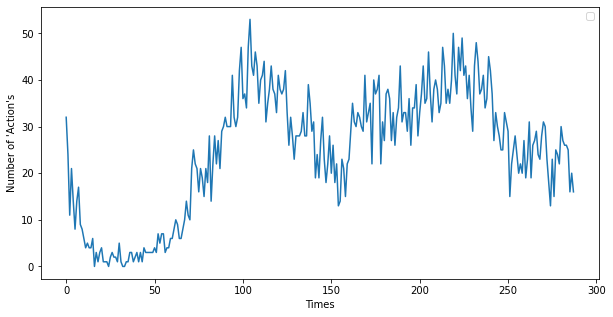

In [ ]:
v = [va[1] for va in plots]
v = [va for va in v]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot([i for i in range(len(v))],[va for va in v])
plt.xlabel("Times")
plt.ylabel("Number of 'Action's")
plt.legend()
plt.show()

# Binary Model

In [ ]:
def makeData(ar, labels):
  vals = numpy.unique(ar)
  dic = {}
  for i in range(len(ar)):
    val = ar[i]
    l = labels[i]
    if val not in dic:
      dic[val] = [0,0]
    dic[val][l] += 1
  for k in dic:
    s = dic[k][0] + dic[k][1]
    dic[k][0] /= s
    dic[k][1] /= s 
  newAr = []
  for i in ar:
    newAr.append(dic[i][1])
  return newAr

In [ ]:
d = pd.read_csv("IP Data Robot Actions - IP Data.csv", header=None).to_numpy()
data = []
YAct = []
for i in range(1,len(d)):
  data.append( [d[i][1], d[i][2], d[i][3], d[i][4]] )
  YAct.append(d[i][4])
  if d[i][4]=="NoAction": 
    data[-1][-1] = 0
  else:
    data[-1][-1] = 1

In [ ]:
YSet = []
Yprev = []
for i in range(0,len(YAct),15):
  temp = []
  tempAct = YAct[i]
  for j in range(i,min(i+15,len(YAct))):
    if YAct[j] not in temp:
      temp.append(YAct[j])
    if YAct[j] != "NoAction":
      tempAct = YAct[j]
  Yprev.append(tempAct)
  YSet.append(temp)
Yprev = ["NoAction"] + Yprev[:-1]

In [ ]:
prev = "Bring a glass of water"
for i in range(len(Yprev)):
  if Yprev[i] == "NoAction":
    Yprev[i] = prev
  else:
    prev = Yprev[i]

In [ ]:
vals =['Switch on the geyser', 'Get the necessary ingredients', 'Lay the dishes on the table', 'Bring the laptop and books', 'Provide the broom and mop', 'Bring a glass of water', 'Keep the broom and mop back', 'Put dishes in the dishwasher', 'Switch off the geyser', 'Put used dishes in the sink', 'Bring a cold beverage', 'Bring the wallet and mobile', 'Keep laptops and books away', 'Put the dishes back in the shelves', 'Switch off the TV ']

In [ ]:
YP = []
for i in Yprev:
  temp = [0]*len(vals)
  if i in vals:
    temp[vals.index(i)] = 1
  YP.append(temp)
YP = numpy.array(YP)

In [ ]:
Data = []
for i in range(0,len(data),15):
  l = False
  for j in range(i,min(i+15,len(data))):
    if data[j][-1] == 1:
      l = True
  d = []
  if l:
    for j in range(i,min(i+15,len(data))):
      if data[j][-1] == 1:
        d = data[j]
        d[1] = data[i][1]
  else:
    d = data[i]
  Data.append(d)

In [ ]:
day = []
time = []
hour = []
minute = []
loct = []
y = []
for i in range(len(Data)):
  day.append(Data[i][0])
  time.append(Data[i][1])
  colon = Data[i][1].find(':')
  hour.append(int(Data[i][1][:colon]))
  minute.append(int(Data[i][1][colon+1:]))
  loct.append(Data[i][2])
  y.append(Data[i][3])
hour = numpy.array(hour)
minute = numpy.array(minute)
Y = numpy.array(y)

In [ ]:
timeProb = numpy.array(makeData(time,Y))
locProb = numpy.array(makeData(loct,Y))

In [ ]:
day, _ = to_one(day)
loct, _ = to_one(loct)

In [ ]:
X = []
window = 100
for i in range(window,len(Y)):  
  X.append(Y[i-window:i])
X = numpy.array(X)
X = X.reshape((X.shape[0],window,1))

In [ ]:
print(day.shape,loct.shape,hour.shape,minute.shape,timeProb.shape,locProb.shape,Y.shape,X.shape,YP.shape)

(21120, 7) (21120, 11) (21120,) (21120,) (21120,) (21120,) (21120,) (21020, 100, 1) (21120, 15)


In [ ]:
endT = 15000
endV = 18000
endTe = -1
trainX = [day[window:endT],loct[window:endT],hour[window:endT],minute[window:endT],timeProb[window:endT],locProb[window:endT],X[:endT-window]]
trainY = Y[window:endT]
valX = [day[endT:endV],loct[endT:endV],hour[endT:endV],minute[endT:endV],timeProb[endT:endV],locProb[endT:endV],X[endT-window:endV-window]]
valY = Y[endT:endV]
testX = [day[endV:endTe],loct[endV:endTe],hour[endV:endTe],minute[endV:endTe],timeProb[endV:endTe],locProb[endV:endTe],X[endV-window:endTe]]
testY = Y[endV:endTe]

testXA = [day[endV:endTe],loct[endV:endTe],hour[endV:endTe],minute[endV:endTe],YP[endV:endTe]]
YS = YSet[endV:endTe]

In [ ]:
print(trainX[0].shape,trainX[1].shape,trainX[2].shape,trainX[3].shape,trainX[4].shape,trainX[5].shape,trainX[6].shape)
print(valX[0].shape,valX[1].shape,valX[2].shape,valX[3].shape,valX[4].shape,valX[5].shape,valX[6].shape)
print(testX[0].shape,testX[1].shape,testX[2].shape,testX[3].shape,testX[4].shape,testX[5].shape,testX[6].shape)
print(testXA[0].shape,testXA[1].shape,testXA[2].shape,testXA[3].shape,testXA[4].shape)
print(trainY.shape,valY.shape,testY.shape)

(14900, 7) (14900, 11) (14900,) (14900,) (14900,) (14900,) (14900, 100, 1)
(3000, 7) (3000, 11) (3000,) (3000,) (3000,) (3000,) (3000, 100, 1)
(3119, 7) (3119, 11) (3119,) (3119,) (3119,) (3119,) (3119, 100, 1)
(3119, 7) (3119, 11) (3119,) (3119,) (3119, 15)
(14900,) (3000,) (3119,)


In [ ]:
Days = Input(shape=(7,))
Locts = Input(shape=(11,))
Hours = Input(shape=(1,))
Minutes = Input(shape=(1,))
TProb = Input(shape=(1,))
LProb = Input(shape=(1,))
LSTMI = Input(shape=(window,1))

Day = Dense(8, activation="relu", input_shape=(7,))(Days)

Loct = Dense(8, activation="relu", input_shape=(11,))(Locts)

Hour = Dense(8, activation="relu", input_shape=(1,))(Hours)
Minute = Dense(8, activation="relu", input_shape=(1,))(Minutes)
Time = concatenate([Hour, Minute])
Time = Dense(8, activation="relu")(Time)

com = concatenate([Day, Loct, Time])
yD = Dense(1, activation="relu")(com)

lstmy = LSTM(1)(LSTMI)
lstmy = Dense(1,activation='relu')(lstmy)

y = concatenate([yD,TProb,LProb,lstmy])
y = Dense(1, activation="sigmoid")(y)

model = Model(inputs=[Days, Locts, Hours, Minutes, TProb, LProb, LSTMI], outputs=y)
opt = Adam(lr=0.0005)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
weight = numpy.count_nonzero(trainY==0)/numpy.count_nonzero(trainY==1)

In [ ]:
mc = ModelCheckpoint('Best_Model1.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX, valY), batch_size=64,
    epochs=40, callbacks=[mc], verbose=0, class_weight={0:1,1:weight})

In [ ]:
model = load_model("Best_Model1.h5")
Ypred = model.predict(testX)
print(classification_report(testY,Ypred.round()))

              precision    recall  f1-score   support

           0       0.89      0.66      0.76      2193
           1       0.51      0.81      0.62       926

    accuracy                           0.71      3119
   macro avg       0.70      0.74      0.69      3119
weighted avg       0.78      0.71      0.72      3119



# Action Model

In [ ]:
d = pd.read_csv("IP Data Robot Actions - IP Data.csv", header=None).to_numpy()
data = []
day = []
time = []
hour = []
minute = []
loct = []
prevAct = []
y = []
for i in range(1,len(d)):
  if d[i][4] != "NoAction":
    data.append( [d[i][1], d[i][2], d[i][3], d[i-1][4]] )
    day.append(d[i][1])
    time.append(d[i][2])
    colon = d[i][2].find(':')
    hour.append(int(d[i][2][:colon]))
    minute.append(int(d[i][2][colon+1:]))
    loct.append(d[i][3])
    if len(y)==0:
      prevAct.append("Switch off the TV ")
    else:
      prevAct.append(y[-1])
    y.append(d[i][4])
hour = numpy.array(hour)
minute = numpy.array(minute)

In [ ]:
day, _ = to_one(day)
loct, _ = to_one(loct)
prevAct, vals = to_one(prevAct)
Y = []
for i in range(len(y)):
  Y.append(vals.index(y[i]))
Y = to_categorical(Y)

In [ ]:
trainX = [day[:8500],loct[:8500],hour[:8500],minute[:8500],prevAct[:8500]]
trainY = Y[:8500]
valX = [day[8500:],loct[8500:],hour[8500:],minute[8500:],prevAct[8500:]]
valY = Y[8500:]

In [ ]:
Days = Input(shape=(7,))
Locts = Input(shape=(11,))
PrevActs = Input(shape=(15,))
Hours = Input(shape=(1,))
Minutes = Input(shape=(1,))

Day = Dense(8, activation="relu", input_shape=(7,))(Days)

Loct = Dense(8, activation="relu", input_shape=(11,))(Locts)

PrevAct = Dense(8, activation="relu")(PrevActs)

Hour = Dense(16, activation="relu", input_shape=(1,))(Hours)
Minute = Dense(16, activation="relu", input_shape=(1,))(Minutes)
Time = concatenate([Hour, Minute])
Time = Dense(8, activation="relu")(Time)

X = concatenate([Day, Loct, Time, PrevAct])

X = Dense(64, activation="relu")(X)
y = Dense(15, activation="softmax")(X)

model = Model(inputs=[Days, Locts, Hours, Minutes, PrevActs], outputs=y)
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX, valY), batch_size=64,
    epochs=100, callbacks=[mc], verbose=0)

In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(valX)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(valY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                                    precision    recall  f1-score   support

             Bring a cold beverage       0.92      0.91      0.91       614
            Bring a glass of water       0.96      0.99      0.97       240
        Bring the laptop and books       0.93      0.93      0.93        40
       Bring the wallet and mobile       1.00      0.96      0.98       111
     Get the necessary ingredients       0.97      0.96      0.97       353
       Keep laptops and books away       1.00      1.00      1.00        38
       Lay the dishes on the table       0.90      0.58      0.70        33
      Put dishes in the dishwasher       0.00      0.00      0.00         3
Put the dishes back in the shelves       1.00      0.75      0.86         4
       Put used dishes in the sink       0.81      0.82      0.81       296
                Switch off the TV        0.95      0.99      0.97       548
             Switch off the geyser       0.00      0.00      0.00         7
           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(vals)

['Switch on the geyser', 'Get the necessary ingredients', 'Lay the dishes on the table', 'Bring the laptop and books', 'Provide the broom and mop', 'Bring a glass of water', 'Keep the broom and mop back', 'Put dishes in the dishwasher', 'Switch off the geyser', 'Put used dishes in the sink', 'Bring a cold beverage', 'Bring the wallet and mobile', 'Keep laptops and books away', 'Put the dishes back in the shelves', 'Switch off the TV ']


# Combine Models

In [ ]:
model = load_model("Best_Model.h5")
YpredA = model.predict(testXA)
YpredA = numpy.argmax(YpredA,axis=1)

In [ ]:
Actions = []
for i in YpredA:
  Actions.append(vals[i])

In [ ]:
c = 0
d = 0
e = 0
f = 0
Ypred = Ypred.round()
for i in range(len(YpredA)):
  p = Ypred[i]
  t = testY[i]
  if p==t and p==0:
    c += 1
    e += 1
  elif p==t and p==1:
    f += 1
    if Actions[i] in YS[i]:
      c += 1
      d += 1
print("Total Accuracy:",c/len(YpredA))
print(d/len(YpredA))
print(e/len(YpredA))
print(f/len(YpredA))

Total Accuracy: 0.6851554985572299
0.21769798012183392
0.46745751843539596
0.24078230201987816


# Occam's Razor

In [ ]:
def makeData(ar, labels):
  vals = numpy.unique(ar)
  dic = {}
  for i in range(len(ar)):
    val = ar[i]
    l = labels[i]
    if val not in dic:
      dic[val] = [0,0]
    dic[val][l] += 1
  for k in dic:
    s = dic[k][0] + dic[k][1]
    dic[k][0] /= s
    dic[k][1] /= s 
  newAr = []
  for i in ar:
    newAr.append(dic[i][1])
  return newAr

In [ ]:
d = pd.read_csv("IP Data Robot Actions - IP Data.csv", header=None).to_numpy()
data = []
YAct = []
for i in range(1,len(d)):
  data.append( [d[i][1], d[i][2], d[i][3], d[i][4]] )
  YAct.append(d[i][4])
  if d[i][4]=="NoAction": 
    data[-1][-1] = 0
  else:
    data[-1][-1] = 1

In [ ]:
YSet = []
Yprev = []
for i in range(0,len(YAct),15):
  temp = []
  tempAct = YAct[i]
  for j in range(i,min(i+15,len(YAct))):
    if YAct[j] not in temp:
      temp.append(YAct[j])
    if YAct[j] != "NoAction":
      tempAct = YAct[j]
  Yprev.append(tempAct)
  YSet.append(temp)
Yprev = ["NoAction"] + Yprev[:-1]

In [ ]:
prev = "Bring a glass of water"
for i in range(len(Yprev)):
  if Yprev[i] == "NoAction":
    Yprev[i] = prev
  else:
    prev = Yprev[i]

In [ ]:
vals = ['Keep the broom and mop back', 'Put used dishes in the sink', 'Switch off the TV ', 'Get the necessary ingredients', 'Switch off the geyser', 'Bring the laptop and books', 'Switch on the geyser', 'Bring a glass of water', 'Bring the wallet and mobile', 'Bring a cold beverage', 'Lay the dishes on the table', 'Provide the broom and mop', 'Put dishes in the dishwasher', 'Put the dishes back in the shelves', 'Keep laptops and books away']

In [ ]:
YP = []
for i in Yprev:
  temp = [0]*len(vals)
  if i in vals:
    temp[vals.index(i)] = 1
  YP.append(temp)
YP = numpy.array(YP)

In [ ]:
Data = []
for i in range(0,len(data),15):
  l = False
  for j in range(i,min(i+15,len(data))):
    if data[j][-1] == 1:
      l = True
  d = []
  if l:
    for j in range(i,min(i+15,len(data))):
      if data[j][-1] == 1:
        d = data[j]
        d[1] = data[i][1]
  else:
    d = data[i]
  Data.append(d)

In [ ]:
day = []
time = []
hour = []
minute = []
loct = []
y = []
for i in range(len(Data)):
  day.append(Data[i][0])
  time.append(Data[i][1])
  colon = Data[i][1].find(':')
  hour.append(int(Data[i][1][:colon]))
  minute.append(int(Data[i][1][colon+1:]))
  loct.append(Data[i][2])
  y.append(Data[i][3])
hour = numpy.array(hour)
minute = numpy.array(minute)
Y = numpy.array(y)

In [ ]:
timeProb = numpy.array(makeData(time,Y))
locProb = numpy.array(makeData(loct,Y))

In [ ]:
day, _ = to_one(day)
loct, _ = to_one(loct)

In [ ]:
X = []
window = 100
for i in range(window,len(Y)):  
  X.append(Y[i-window:i])
X = numpy.array(X)
X = X.reshape((X.shape[0],window,1))

In [ ]:
print(day.shape,loct.shape,hour.shape,minute.shape,timeProb.shape,locProb.shape,Y.shape,X.shape)

(21120, 7) (21120, 11) (21120,) (21120,) (21120,) (21120,) (21120,) (21020, 100, 1)


In [ ]:
endT = 15000
endV = 18000
endTe = -1
trainX = [day[window:endT],loct[window:endT],hour[window:endT],minute[window:endT],X[:endT-window]]
trainY = Y[window:endT]
valX = [day[endT:endV],loct[endT:endV],hour[endT:endV],minute[endT:endV],X[endT-window:endV-window]]
valY = Y[endT:endV]
testX = [day[endV:endTe],loct[endV:endTe],hour[endV:endTe],minute[endV:endTe],X[endV-window:endTe]]
testY = Y[endV:endTe]

testXA = [day[endV:endTe],loct[endV:endTe],hour[endV:endTe],minute[endV:endTe],YP[endV:endTe]]
YS = YSet[endV:endTe]

In [ ]:
print(trainX[0].shape,trainX[1].shape,trainX[2].shape,trainX[3].shape,trainX[4].shape)
print(valX[0].shape,valX[1].shape,valX[2].shape,valX[3].shape,valX[4].shape)
print(testX[0].shape,testX[1].shape,testX[2].shape,testX[3].shape,testX[4].shape)
print(testXA[0].shape,testXA[1].shape,testXA[2].shape,testXA[3].shape,testXA[4].shape)
print(trainY.shape,valY.shape,testY.shape)

(14900, 7) (14900, 11) (14900,) (14900,) (14900, 100, 1)
(3000, 7) (3000, 11) (3000,) (3000,) (3000, 100, 1)
(3119, 7) (3119, 11) (3119,) (3119,) (3119, 100, 1)
(3119, 7) (3119, 11) (3119,) (3119,) (3119, 15)
(14900,) (3000,) (3119,)


In [ ]:
Days = Input(shape=(7,))
Locts = Input(shape=(11,))
Hours = Input(shape=(1,))
Minutes = Input(shape=(1,))
# TProb = Input(shape=(1,))
# LProb = Input(shape=(1,))
LSTMI = Input(shape=(window,1))

Day = Dense(8, activation="relu", input_shape=(7,))(Days)

Loct = Dense(8, activation="relu", input_shape=(11,))(Locts)

Hour = Dense(8, activation="relu", input_shape=(1,))(Hours)
Minute = Dense(8, activation="relu", input_shape=(1,))(Minutes)
Time = concatenate([Hour, Minute])
Time = Dense(8, activation="relu")(Time)

com = concatenate([Day, Loct, Time])
yD = Dense(1, activation="relu")(com)

lstmy = LSTM(1)(LSTMI)
lstmy = Dense(1,activation='relu')(lstmy)

y = concatenate([yD,lstmy])
y = Dense(1, activation="sigmoid")(y)

model = Model(inputs=[Days, Locts, Hours, Minutes, LSTMI], outputs=y)
opt = Adam(lr=0.0005)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
weight = numpy.count_nonzero(trainY==0)/numpy.count_nonzero(trainY==1)

In [ ]:
mc = ModelCheckpoint('Best_Model1.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX, valY), batch_size=64,
    epochs=40, callbacks=[mc], verbose=0, class_weight={0:1,1:weight})

In [ ]:
model = load_model("Best_Model1.h5")
Ypred = model.predict(testX)
print(classification_report(testY,Ypred.round()))

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      2193
           1       0.51      0.78      0.62       926

    accuracy                           0.71      3119
   macro avg       0.70      0.73      0.70      3119
weighted avg       0.77      0.71      0.73      3119

